## Exploring IRS 990 XMLs with Python and Elasticsearch

In the first set of notebooks, we went over the basic parts of Python that are commonly used for data processing tasks.  In this set, we'll go over some useful libraries and addons, using some concrete examples. 

We'll start by seeing what we can do with the publicly-available IRS 990s, downloading and parsing the data, enriching it with ancillary data, exploring and analyzing it further, and building a web service to share the results.

General information about the IRS 990 forms is available here.

https://aws.amazon.com/public-datasets/irs-990/

The data is made available via an index file that lists the returns for each year.  

https://s3.amazonaws.com/irs-form-990/index_2016.json

You might want to install a chrome extension to format the json in a viewable form:

https://chrome.google.com/webstore/detail/xv-%E2%80%94-xml-viewer/eeocglpgjdpaefaedpblffpeebgmgddk?utm_source=chrome-app-launcher-info-dialog

The returns themselves are in XML format.  Here's an example:

https://s3.amazonaws.com/irs-form-990/201523229349300307_public.xml

Similarly, a browser plugin that formats XML can be helpful:

https://chrome.google.com/webstore/detail/xv-%E2%80%94-xml-viewer/eeocglpgjdpaefaedpblffpeebgmgddk?utm_source=chrome-app-launcher-info-dialog

The return format changes from year to year and between return types.  For simplicity's sake, we can just focus on 2015 990s as listed in the 2016 index file.  The general outline of steps we need to take is:

1. Figure out which urls to access. The index file for each year can contain returns from multiple years and return types, so we need to get the urls only for 2016 and where the return type is 990. 
2. Open up the XML and pull out the fields we're interested in. To do this, we have to figure out where in the XML structure these fields are:
3. Save these locally.
4. Extract some usable information from the data, or append some ancillary data.
5. Store and retrieve the data.

Step 4 will take some iteration to see what's possible.

### Getting data from a URL

The first step is to figure out what URLs to download.  We can use the IRS index file to get these urls.  The following snippet has some steps that need to be completed. The result should be a file containing the URLs we're interested in. 

In [ ]:
import requests
import json

# Get the index file.
response = requests.get("https://s3.amazonaws.com/irs-form-990/index_2016.json")
# Load it into a Python dictionary.
data = json.loads(response.text)
urls = []
# Go through each item and pull out the rows:
for return_metadata in data["Filings2016"]:
    # Code that needs to be completed - only look at records where TaxPeriod starts with "2015" and FormType = "990",
    # and append the url to the url list:
    # ******** Your code here ***********
    pass
    # ***********************************    
# Write out the urls to a file
with open("urls.txt", "w") as f:
    f.writelines(urls)

print ("All done!")

### Getting the fielded data from the XML
Now that we know what URLs to check, we can go through these and get data from the XML files.  The _**xmltodict**_ python module can parse the XML into a dictionary for us.  Some fields we might find interesting are:

* **EIN**:     ```Return->ReturnHeader->Filer->EIN```
* **Name**:    ```Return->ReturnHeader->Filer->BusinessName->BusinessNameLine1Txt```
* **Address**: ```Return->ReturnHeader->Filer->USAddress->AddressLine1Txt```
* **City**:    ```Return->ReturnHeader->Filer->USAddress->CityNm```
* **State**:   ```Return->ReturnHeader->Filer->USAddress->StateAbbreviationCd```
* **Zip**:     ```Return->ReturnHeader->Filer->USAddress->ZIPCd```
* **Officer**: ```Return->ReturnHeader->BusinessOfficerGrp->PersonNm```
* **Revenue**: ```Return->ReturnData->IRS990->CYTotalRevenueAmt```
* **Mission**: ```Return->ReturnData->IRS990->ActivityOrMissionDesc```


In [ ]:
import requests
import csv
import xmltodict

# Load the URLs into a list
urls = []
with open("urls.txt") as f:
    urls = f.readlines()

output = []
for url in urls:
    # Get the return data
    response = requests.get(url.replace("\n", ""))
    # Parse it into a dictionary
    return_data = xmltodict.parse(response.content)
    # We need to add code to get each element into a dictionary, with the key being the name of the value, and the 
    # value being the field value in the xml.  Once the dictionary is set up, it needs to be added to the output list.
    
    # ******** Your code here ***********
    pass
    # ***********************************    

    # Limit results for now, so we don't have to wait all day.
    if len(output) > 100:
        break

field_names = # Your code here - construct a list of the field names 
with open("data.txt", "w") as f:
    dw = csv.DictWriter(f, delimiter="\t", fieldnames=field_names)
    dw.writeheader()
    dw.writerows(output)

print ("All done!")

## Elasticsearch

Elasticsearch is a "no-sql" document-oriented data store that uses an inverted index structure for fast queries.  It also supports, like SQL, aggregations, so you can get quantitative results as well as text search results.

https://www.elastic.co/guide/en/elasticsearch/reference/current/getting-started.html

You can interact with elasticsearch using HTTP requests, or using a wrapper library like the elasticsearch python library, which makes life a little easier:

https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch

If you don't have the elasticsearch package installed on your machine, you can use this command to install it:

```
pip install elasticsearch
```

Pip is a "package manager", that consults an online database (https://pypi.python.org/pypi) for information about registered software and what versions are appropriate for which OS/Python version combination:

https://pip.pypa.io/en/stable/quickstart/

You can install Elasticsearch on your local machine, or for this class, use the server at fcsearchdev04.  We can load the data we downloaded into the index with the code below:

In [ ]:
import csv
from elasticsearch import Elasticsearch

# This line connects to the elastic instance, just like a SQL Server connection (we might need to use the fully-qualified name
# or IP address to connect).
es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]"))
# The next line deletes an index if it exists.  The ignore parameter tells it to ignore the error if the index doesn't exist yet:
es.indices.delete(index='[your initials]', ignore=[400, 404])
with open("data.txt") as f:
    dr = csv.DictReader(f, delimiter="\t")
    for d in dr:
        # This line create a new document with default field types.
        es.create(index="[your initials]", body=d, doc_type="document", id=d["ein"])
print ("All done!")

### Querying the data

Now that we have some data loaded, let's look at querying it. Elasticsearch supports a data query format analagous to SQL, but with a different syntax, referred to as a "DSL" (domain-specific language) in JSON format.

https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl.html

Match query DSL:

https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-match-query.html

In [ ]:
from elasticsearch import Elasticsearch

es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]"))

q = # Your code here - look up in the elastic docs how to do a match query, and look for a matching word in the mission statement
r = es.search(index="[your initials]", body=q)

for d in r["hits"]["hits"]:
    # Your code here - look in the results for the name and mission statement in the _source field of the results
    pass
print ("All done!")

There are many variants of these queries.  For example, we can use a fuzzy query to get text with nearby words, to account for slight misspellings:

https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-fuzzy-query.html
https://www.elastic.co/guide/en/elasticsearch/reference/current/common-options.html#fuzziness

In [ ]:
from elasticsearch import Elasticsearch

es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]"))
q = {
    "query": {
        "fuzzy": {"[your initials]": "haite"}
    }
}
r = es.search(index="gmg", body=q)
for d in r["hits"]["hits"]:
    print(d["_source"]["name"])
print ("All done!")


### Sharing the data

Python libraries make it easy to spin up web services to share data.  You can run Python from a web server, but it's more convenient and secure to use a package like Flask or CherryPy that are designed for this purpose.  To create a web service using CherryPy, it is simply a matter of wrapping your function in an object, adding an "exposed" property to the function name you want to make available, and starting up a CherryPy web server.



In [ ]:
from elasticsearch import Elasticsearch
import cherrypy
import json

es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]"))

class Search():
    def search(self, s):
        q = {
            "query": {
                "fuzzy": {"name": s}
            }
        }
        r = es.search(index="[your initials]", body=q)
        result = []
        for d in r["hits"]["hits"]:
            result.append(d)

        return json.dumps(result)

    search.exposed = True

cherrypy.quickstart(Search())

We can enhance our service a little by adding some more items to our search fields using the multi-match search type:

https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-multi-match-query.html

In [ ]:
from elasticsearch import Elasticsearch
import cherrypy
import json

es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]"))

class Search():
    def search(self, s):
        q = # Your code here up a multi match query and search across multiple fields here.
        r = es.search(index="[your initials]", body=q)
        result = []
        for d in r["hits"]["hits"]:
            result.append(d)

        return json.dumps(result)

    search.exposed = True

cherrypy.quickstart(Search())

### Enhancing the data

Now that we have a bare-bones process in place, we can look at enhancing it.  One way to do this would be to use Foundation Center's autoclassification API to add subject information to our search index.

https://apibeta.foundationcenter.org/docs/v2.0/console.html#/GET%20/text/autoclassification

In [6]:
import requests
import csv
import json

s = requests.Session()
s.auth = ("[provided in class]", "[provided in class]")
url = "https://apibeta.foundationcenter.org//v2.0/text/autoclassification?taxonomy=pcs&threshold=90&chunk_text=false&text="
output = []
field_names = []
with open("data.txt") as f:
    dr = csv.DictReader(f, delimiter="\t")
    field_names = dr.fieldnames
    for d in dr:
        # This line create a new document with default field types.
        # *********** Your code here **************
        # Get the mission statement and name and pass it off to the api using s.get(),
        # then take the first response in the subject facet and add it to the dictionary 
        # using the "subject" key.
        # *****************************************
        output.append(d)

with open("data_with_subjects.txt", "w") as f:
    field_names.append("subject")
    dw = csv.DictWriter(f, delimiter="\t", fieldnames=field_names)
    dw.writeheader()
    dw.writerows(output)

print("All done!")

TypeError: 'Response' object is not subscriptable

Now, let's load the enhanced data into the index

In [2]:
import csv
from elasticsearch import Elasticsearch

es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]")))
es.indices.delete(index='gmg', ignore=[400, 404])
with open("data_with_subjects.txt") as f:
    dr = csv.DictReader(f, delimiter="\t")
    for d in dr:
        es.create(index="gmg", body=d, doc_type="document", id=d["ein"])
print ("All done!")

All done!


Elasticsearch aggregations can be useful for doing SQL-like queries of documents.  There are many flavors of aggregations.  The terms aggregation is probably a good starting point.  You can add a terms aggregation to the example below to get the number of returns per subject. Note that you will need to use the field called "subject.keyword", which elastic creates automatically (you can't aggregate on a normal text field, only a simplified keyword field):

https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-terms-aggregation.html

In [ ]:
from elasticsearch import Elasticsearch

es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]")))
q = {
  "size": 0,
  "aggregations" : # Your code here
  }
}
r = es.search(index="gmg", body=q)
for d in r["aggregations"]["subjects"]["buckets"]:
    print(d["key"], d["doc_count"])
print ("All done!")

Using what we learned about creating bar charts in the first class, can you create a bar chart of the counts per state?

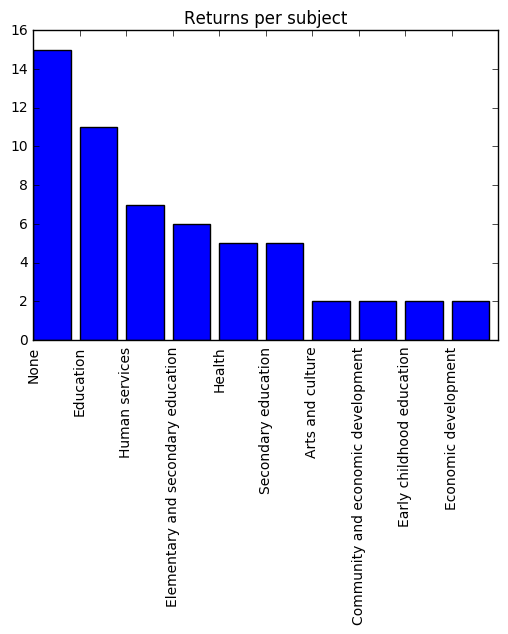

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch

#  ************* Your code here ******************
# You will need to run the query and get the counts
# into a list called items and the bucket keys into 
# a list called labels.

plt.bar(range(len(items)), height=items)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.title("Returns per subject")
plt.show()

Finally, let's create a web service that returns the subject counts for records where the mission statement contains a given string.  This would be the same structure as the web service above, but combining the query and the aggregation, and output the aggregation buckets as in the example above.


In [1]:
# ************** Your code here *******************















### Answers - don't peek!

In [ ]:
    if return_metadata["TaxPeriod"].startswith("2015") and return_metadata["FormType"] == "990":
        urls.append(return_metadata["URL"] + "\n")


In [ ]:
    output_dict = {}
    output_dict["ein"] = return_data["Return"]["ReturnHeader"]["Filer"]["EIN"]
    output_dict["name"] = return_data["Return"]["ReturnHeader"]["Filer"]["BusinessName"]["BusinessNameLine1Txt"]
    if "USAddress" in return_data["Return"]["ReturnHeader"]["Filer"].keys():
        output_dict["address"] = return_data["Return"]["ReturnHeader"]["Filer"]["USAddress"]["AddressLine1Txt"]
        output_dict["city"] = return_data["Return"]["ReturnHeader"]["Filer"]["USAddress"]["CityNm"]
        output_dict["state"] = return_data["Return"]["ReturnHeader"]["Filer"]["USAddress"]["StateAbbreviationCd"]
        output_dict["zip"] = return_data["Return"]["ReturnHeader"]["Filer"]["USAddress"]["ZIPCd"]
    output_dict["officer"] = return_data["Return"]["ReturnHeader"]["BusinessOfficerGrp"]["PersonNm"]
    output_dict["revenue"] = return_data["Return"]["ReturnData"]["IRS990"]["CYTotalRevenueAmt"]
    output_dict["mission"] = return_data["Return"]["ReturnData"]["IRS990"]["ActivityOrMissionDesc"]
    output.append(output_dict)

In [ ]:
{
    "query": {
        "match" : {
            "mission" : "health"
        }
    }
}

print(d["_source"]["name"], d["_source"]["mission"])


In [ ]:
        text = d["mission"] + " " + d["name"]
        response = s.get(url + text.lower())
        response_dict = json.loads(response.text)
        subject_str = ""
        for r in response_dict["data"]["results"]:
            if r["facet"] == "subject":
                # Let's just grab the first subject
                d["subject"] = r["description"]
                break

In [ ]:
{
  "subjects" : {
      "terms" : { "field" : "subject.keyword" }
  }
}

In [ ]:
from elasticsearch import Elasticsearch
import cherrypy
import json

es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]"))

class Search():
    def search(self, s):
        q = {
            "query": {
                "fuzzy": {"subject": s}
            }
        }
        r = es.search(index="gmg", body=q)
        result = []
        for d in r["hits"]["hits"]:
            result.append(d)

        return json.dumps(result)

    search.exposed = True

cherrypy.quickstart(Search())

In [ ]:
es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]"))
q = {
  "size": 0,
  "aggregations" : {
     "subjects" : {
         "terms" : { "field" : "subject.keyword" }
    }
  }
}
r = es.search(index="[your initials]", body=q)
items = []
for d in r["aggregations"]["subjects"]["buckets"]:
    items.append(d["doc_count"])


In [ ]:
es = Elasticsearch("http://172.16.7.122:9200", http_auth=("[provided in class]", "[provided in class]"))
q = {
  "size": 0,
  "aggregations" : {
     "subjects" : {
         "terms" : { "field" : "subject.keyword" }
    }
  }
}
r = es.search(index="gmg", body=q)
items = []
labels = []
for d in r["aggregations"]["subjects"]["buckets"]:
    items.append(d["doc_count"])
    labels.append(d["key"])